In [76]:
import numpy as np
import pandas as pd
from scipy.stats import norm
from scipy.stats import skellam
import matplotlib.pyplot as plt
import math
import scipy.special

In [77]:
#Importing and creating our datframe
Data10=pd.read_csv("../Data/2009-2010.csv")
Data9=pd.read_csv("../Data/2008-2009.csv")
Data8=pd.read_csv("../Data/2007-2008.csv")
Data7=pd.read_csv("../Data/2006-2007.csv")
Data=pd.concat([Data7,Data8,Data9,Data10],sort=False,ignore_index=True)
Data=Data[['HomeTeam','AwayTeam','FTHG','FTAG','FTR']]
Data.columns=['Home','Away','HG','AG','Result']
Out=["Lecce","Messina","Ascoli","Reggina","Empoli","Torino"]
for out in Out:
    Data = Data.loc[Data.Home != out]
    Data = Data.loc[Data.Away != out]
Data=Data.reset_index()
Team=Data.Home.value_counts().index
Data['diff_score']=Data['HG']-Data['AG']


In [78]:
#Creating a dataframe with the updating coeficients 
coef=pd.DataFrame({'Team':Team})
coef['Att']=np.random.normal(0,0.01,len(coef))
coef['Dif']=np.random.normal(0,0.01,len(coef))
coef.iloc[0]['Att']=coef.iloc[0]['Att'] -sum(coef['Att'].values)
coef.iloc[0]['Dif']=coef.iloc[0]['Dif'] -sum(coef['Dif'].values)
#For identifiability need to set first team
coef=coef.set_index('Team').sort_index()

delta = np.random.normal(0,0.01)



C:\Users\marco\Desktop\Python\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """
C:\Users\marco\Desktop\Python\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [80]:
#Calculate the means of our distribution
def score_coef(att,dif,delta,Data):
    mu1=np.array([])
    mu2=np.array([])
    for i in Data.index:
        m1=np.exp(delta+att.loc[Data.loc[i].Home]-dif.loc[Data.loc[i].Away])
        m2=np.exp(att.loc[Data.loc[i].Away]-dif.loc[Data.loc[i].Home])
        mu1=np.append(mu1,m1)
        mu2=np.append(mu2,m2)
    return mu1, mu2

In [81]:
def log_prior (coef_att,coef_dif,delta):
    e= norm.logpdf(delta, loc=0, scale=0.1)
    for i in range(len(coef_att)):
        e=+ norm.logpdf(coef_att[i], loc=0, scale=0.1)+ norm.logpdf(coef_dif[i], loc=0, scale=0.01)
    return e

In [82]:
def log_poisson(mu1,mu2,Data):
    D=0
    for i in range(len(Data)):
        D+=Data['HG'].iloc[i]*np.log(mu1.iloc[i])-mu1.iloc[i]-np.log(math.factorial(Data['HG'].iloc[i]))+Data['AG'].iloc[i]*np.log(mu2.iloc[i])-mu2.iloc[i]-np.log(math.factorial(Data['AG'].iloc[i]))
    return D

In [83]:
#Calculate unomralised log posterior
def log_tot (Data,X):
    coef_att=np.concatenate(([-sum(X[1:20])],X[1:20]))
    coef_def=np.concatenate(([-sum(X[20:39])],X[20:39]))
    H=X[0]
    N=log_prior(coef_att,coef_def,H)
    coef['i1']=coef_att
    coef['i2']=coef_def
    L1,L2=score_coef(coef['i1'],coef['i2'],H,Data)
    Data['j1']=L1
    Data['j2']=L2
    N+=log_poisson(Data['j1'],Data['j2'],Data)
    return N 

In [84]:
#Approximate the gradient of our log_posterior likelihood by finite differences 
def approx_gradient(Data,X,h=0.01):
    X_1=np.copy(X)
    X_2=np.copy(X)
    grad=np.ones(len(X_1))
    for i in range(0,len(X_1)):
        X_1[i]+=h
        X_2[i]-=h
        unnorm1=log_tot(Data,X_1)
        unnorm2=log_tot(Data,X_2)
        grad[i]=(unnorm1-unnorm2)/(2*h)
        X_2[i]+=h
        X_1[i]-=h
    return grad
        

In [87]:
def Gradient_Descent(Data,X0,max_iter=340,rate=0.00005):
    coef=X0
    energy=[]
    for i in range(1,max_iter+1):
        grad=approx_gradient(Data,coef)
        grad=np.multiply(-1,grad)
        coef=coef-rate*grad
        unorm=log_tot(Data,coef)
        print(unorm)
        energy.append(unorm)
    return coef,energy
    


In [88]:
theta0=np.concatenate(([[delta],coef['Att'][1:20],coef['Dif'][1:20]]))
theta0

array([ 0.00052536,  0.00436756,  0.00876536,  0.00931063,  0.00753104,
       -0.00023107,  0.01970998,  0.0035182 , -0.00340226, -0.01036249,
       -0.00288192,  0.0091388 ,  0.00222119,  0.003297  ,  0.01422009,
       -0.01407744,  0.0033484 , -0.01848003, -0.01658926,  0.00592359,
       -0.00347974,  0.00796624, -0.00345511,  0.01210636,  0.00070989,
        0.00725514, -0.00092411,  0.01114197,  0.01477904, -0.02115953,
        0.00414302,  0.01798274,  0.00049898, -0.00362661, -0.01295904,
       -0.01858433,  0.00389994, -0.00851069,  0.0010032 ])

In [89]:
New_coef,energy =Gradient_Descent(Data,theta0)

-3388.393550963557
-3370.943193337754
-3355.4301208214974
-3341.6624628041804
-3329.461411982536
-3318.6607828453207
-3309.1071108032725
-3300.659640978133
-3293.190107086081
-3286.5823225388986
-3280.731627112548
-3275.5442309988775
-3270.9364920361936
-3266.8341556307582
-3263.1715812322354
-3259.890974317067
-3256.941638605174
-3254.2792596028057
-3251.8652274592496
-3249.666004494413
-3247.652540555476
-3245.7997375575205
-3244.0859631191884
-3242.4926120840346
-3241.0037138821676
-3239.6055830977743
-3238.286510225692
-3237.036489389106
-3235.846979715351
-3234.710697096566
-3233.621433170676
-3232.5738985215653
-3231.5635872970515
-3230.586660664389
-3229.6398467523245
-3228.7203549589676
-3227.8258027272113
-3226.954153101954
-3226.103661580538
-3225.272830949943
-3224.4603729697483
-3223.6651759083993
-3222.886277073551
-3222.1228395947105
-3221.3741328199976
-3220.6395157798247
-3219.9184232490165
-3219.210354007635
-3218.51486096002
-3217.8315428222586
-3217.160037132771
-321

In [90]:
coef['Pred_Att']=np.concatenate(([-sum(New_coef[1:20])],New_coef[1:20]))
coef['Pred_Dif']=np.concatenate(([-sum(New_coef[20:])],New_coef[20:]))
coef['Home_Adv']=New_coef[0]

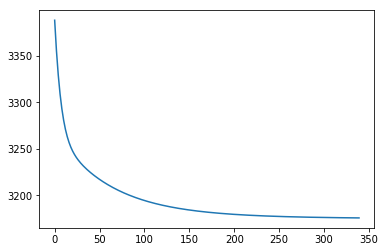

In [103]:
Neg_log_likeli=np.multiply(-1,energy)
plt.plot(Neg_log_likeli)
plt.savefig('grad_descent.png')
plt.show()